# Assignment 7 (Week 9)

## Name: Eniola Ogunmona 

<br>

## Building an ML model to predict review sentiment.


### Introduction
The goal of this project is to build a machine learning model that can predict whether a given review is positive, neutral or negative. To achieve this, the data will first be preprocessed, features extracted, and finally the model will be trained. After the model has been trained, its performance will be evaluated.

- The data can be found [here](https://www.kaggle.com/datasets/nenamalikah/nlp-ulta-skincare-reviews).

> This data contains reviews of Dermalogica skincare products
>
> It would be great to go over the reviews and understand which are poistive, neutral or negative
>
> In this project, I aim to build a machine learning model that can predict whether a review is positive, neutral or negative based on its text content. The model will be trained on a dataset of reviews and corresponding labels, where each label is either `"positive"`, `"neutral"` or `"negative"`.

### Data Dictionary

```
- Review_Title: The title of the review.
- Review_Text: The full text of the review.
- Verified_Buyer: Whether the reviewer is a verified buyer of the product.
- Review_Date: The date the review was published relative to the review scrape date.
- Review_Location: The location of the reviewer.
- Review_Upvotes: How many times the review was upvoted by other reviewers.
- Review_Downvotes: How many times the review was downvoted by other reviewers.
- Product: The name of the product the review was issued for.
- Brand: The brand of the product.
- Scrape_Date: The date the data was pulled from the web.

```

### Table of Contents
- [Exploratory data analysis](#eda)
- [Data preprocessing](#dataprep)
- [Model training](#modeltrain)
- [Model evaluation](#modeleval)
- [Conclusion](#conclusion)

### Loading important libraries for the project

In [1]:
# Built-in library
import itertools
import re
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")


# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 1_000


# Black code formatter (Optional)
%load_ext nb_black

<IPython.core.display.Javascript object>

<a id="eda"><a/>
### Exploratory data analysis

In [2]:
# Loading data

df = pd.read_csv("New-data.csv")

df.head(2)

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date,Sentiment
0,Perfect,Love using this on my face while in the shower. Heats up and gives a light scrub nicely,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,Positive
1,You need this,Even better than the daily microfoliant. I'm obsessed. My skin is SO MUCH smoother,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,Positive


<IPython.core.display.Javascript object>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4146 entries, 0 to 4145
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review_Title      4146 non-null   object
 1   Review_Text       4146 non-null   object
 2   Verified_Buyer    4146 non-null   object
 3   Review_Date       4146 non-null   object
 4   Review_Location   4146 non-null   object
 5   Review_Upvotes    4146 non-null   int64 
 6   Review_Downvotes  4146 non-null   int64 
 7   Product           4146 non-null   object
 8   Brand             4146 non-null   object
 9   Scrape_Date       4146 non-null   object
 10  Sentiment         4146 non-null   object
dtypes: int64(2), object(9)
memory usage: 356.4+ KB


<IPython.core.display.Javascript object>

In [4]:
# checking for null values
df.isna().sum()

Review_Title        0
Review_Text         0
Verified_Buyer      0
Review_Date         0
Review_Location     0
Review_Upvotes      0
Review_Downvotes    0
Product             0
Brand               0
Scrape_Date         0
Sentiment           0
dtype: int64

<IPython.core.display.Javascript object>

In [5]:
# let's see the product column
df["Product"].value_counts()

Product
Daily Superfoliant             1500
Daily Microfoliant             1496
Hydro Masque Exfoliant          800
Multi-Vitamin Thermafoliant     350
Name: count, dtype: int64

<IPython.core.display.Javascript object>

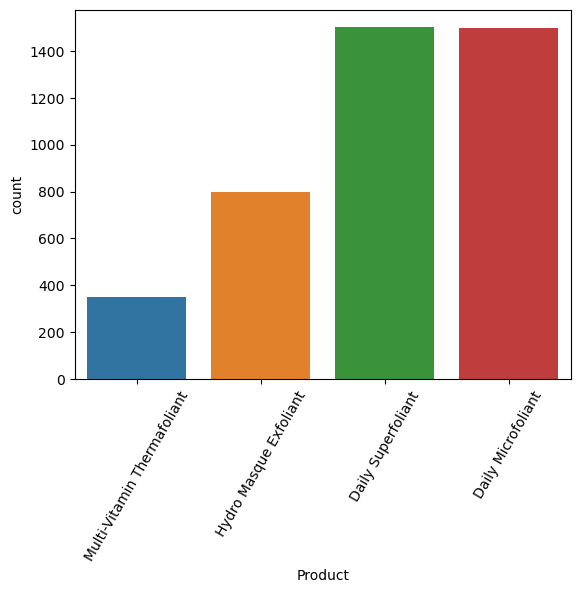

<IPython.core.display.Javascript object>

In [6]:
# let's vsiualize the count of the product column
sns.countplot(data=df, x="Product")
plt.xticks(rotation=60)
plt.show()

Exploring other columns

In [7]:
df["Brand"].unique()

array(['Dermalogica'], dtype=object)

<IPython.core.display.Javascript object>

The brand column contains only one variable, this may have to be dropped

In [8]:
df["Review_Upvotes"].value_counts().sort_index()

Review_Upvotes
0     3145
1      542
2      218
3       89
4       48
5       29
6       11
7       16
8        5
9        9
10       5
11       4
12       6
13       4
14       5
15       2
16       1
17       1
19       1
20       1
25       2
47       1
84       1
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
df["Review_Downvotes"].value_counts().sort_index()

Review_Downvotes
0     3782
1      261
2       54
3       19
4        7
5        3
6        2
7        6
8        1
9        6
10       1
11       1
13       1
14       1
35       1
Name: count, dtype: int64

<IPython.core.display.Javascript object>

The review upvotes and downvotes have various counts. This would have to be scaled, normalized 

In [10]:
df["Review_Location"].nunique()

1423

<IPython.core.display.Javascript object>

There are a lot of unique values for review location, the column may have to dropped

<a id="dataprep"></a>
### Data preprocessing
Before training the model, it is important to preprocess the data to prepare it for machine learning. This typically involves several steps such as:
```
- Feature engineering: 

- Text cleaning: Removing irrelevant characters, stopwords, and punctuation marks from the text.

- Tokenization: Splitting the text into individual words or tokens.

- Vectorization: Converting the tokens into numerical vectors that can be used as input to the machine learning algorithm. This can be done using techniques such as bag-of-words, word embeddings, or character-level features.

- Splitting the dataset: Splitting the dataset into training, validation, and test sets to evaluate the performance of the model.
```

**Performing some feature engineering**

I am trying to capture the patterns in the review date column and discretise

In [11]:
df["Review_Date"].unique()

array(['15 days ago', '27 days ago', '2 months ago', '3 months ago',
       '4 months ago', '5 months ago', '6 months ago', '7 months ago',
       '8 months ago', '9 months ago', '10 months ago', '11 months ago',
       '1 year ago', '2 years ago', '3 years ago', '4 years ago',
       '5 years ago', '6 years ago', '7 years ago', '8 years ago',
       '9 years ago', '10 years ago', '11 years ago', '1 month ago',
       '7 days ago', '16 days ago', '17 days ago', '18 days ago',
       '19 days ago', '20 days ago', '22 days ago', '23 days ago',
       '25 days ago', '28 days ago', '29 days ago', '4 days ago',
       '5 days ago', '12 days ago', '14 days ago', '21 days ago',
       '24 days ago'], dtype=object)

<IPython.core.display.Javascript object>

In [12]:
date_patterns = {
    r"(\d*\W+days ago)": "Less than 1 month",
    r"(\d{1,2}\s+months? ago)": "Less than 1 year",
    r"([2-5]\s+years ago|[1]\s+year ago)": "1 to 5 years",
    r"([6-9]\s+years ago|\d{2}\s+years ago)": "More than 5 years",
}


for pattern, replacement in date_patterns.items():
    df["Review_Date"] = df["Review_Date"].str.replace(pattern, replacement, regex=True)

<IPython.core.display.Javascript object>

In [13]:
df["Review_Date"].unique()

array(['Less than 1 month', 'Less than 1 year', '1 to 5 years',
       'More than 5 years'], dtype=object)

<IPython.core.display.Javascript object>

The unique dates are just 4 now

<br>

It would be good to combine the review title and review texxt into one column so as to preprocess properly

In [14]:
df["Review"] = df["Review_Title"] + " " + df["Review_Text"]
df = df.drop(labels=["Review_Title", "Review_Text"], axis=1)
df.head(2)

,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date,Sentiment,Review
0,No,Less than 1 month,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,Positive,Perfect Love using this on my face while in the shower. Heats up and gives a light scrub nicely
1,No,Less than 1 month,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,Positive,You need this Even better than the daily microfoliant. I'm obsessed. My skin is SO MUCH smoother


<IPython.core.display.Javascript object>

<br>

Creating a new column that grabs the length of the review given

In [15]:
df["Review_length"] = df["Review"].apply(len)
print(df.shape)
df.head(2)

(4146, 11)


,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date,Sentiment,Review,Review_length
0,No,Less than 1 month,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,Positive,Perfect Love using this on my face while in the shower. Heats up and gives a light scrub nicely,95
1,No,Less than 1 month,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,Positive,You need this Even better than the daily microfoliant. I'm obsessed. My skin is SO MUCH smoother,96


<IPython.core.display.Javascript object>

**Encoding the target variable**

In [16]:
mapper = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
}

df["Sentiment"] = df["Sentiment"].map(mapper)
df["Sentiment"].unique()

array([2, 1, 0], dtype=int64)

<IPython.core.display.Javascript object>

**There are 4 unique products, I would like to create a wordcloud showing the words/phrases commonly associated with each product**

In [17]:
df.Product.unique()

array(['Multi-Vitamin Thermafoliant', 'Hydro Masque Exfoliant',
       'Daily Superfoliant', 'Daily Microfoliant'], dtype=object)

<IPython.core.display.Javascript object>

In [18]:
# grabbing the the rows associated with each product
therma_df = df[df["Product"] == "Multi-Vitamin Thermafoliant"]
super_df = df[df["Product"] == "Daily Superfoliant"]
micro_df = df[df["Product"] == "Daily Microfoliant"]
exfo_df = df[df["Product"] == "Hydro Masque Exfoliant"]
exfo_df.head(1)

,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date,Sentiment,Review,Review_length
350,No,Less than 1 year,Undisclosed,0,0,Hydro Masque Exfoliant,Dermalogica,3/27/23,2,Hydro masque exfoliant This masque is gentle and easy to use.,61


<IPython.core.display.Javascript object>

In [19]:
def extract_reviews(df):
    """This functions extract the reviews contained in a dataframe"""
    reviews = []
    for review in df.Review:
        reviews.append(review)
        return " ".join(reviews)


therma_words = extract_reviews(therma_df)
super_words = extract_reviews(super_df)
micro_words = extract_reviews(micro_df)
exfo_words = extract_reviews(exfo_df)

<IPython.core.display.Javascript object>

In [20]:
def generate_wordcloud(text):
    """This function helps to generate a wordcloud when text is passed in"""
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40,
        relative_scaling=0.5,
        colormap="summer",
    ).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>

**Wordcloud showing words commonly associated with the Multi-Vitamin Thermafoliant product**

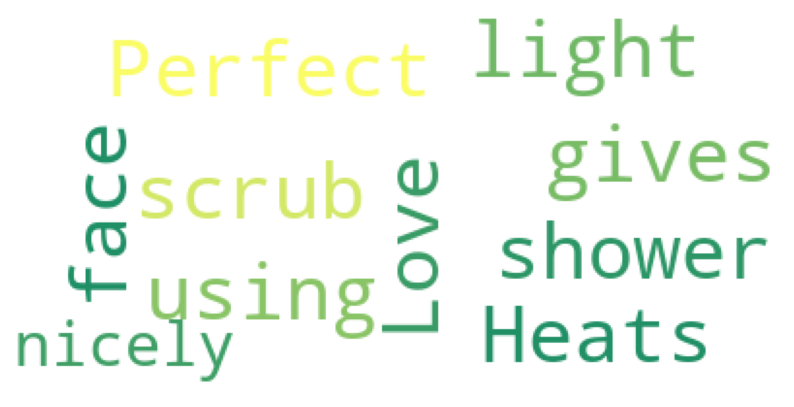

<IPython.core.display.Javascript object>

In [21]:
generate_wordcloud(therma_words)

**Wordcloud showing words commonly associated with the Daily Superfoliant product**

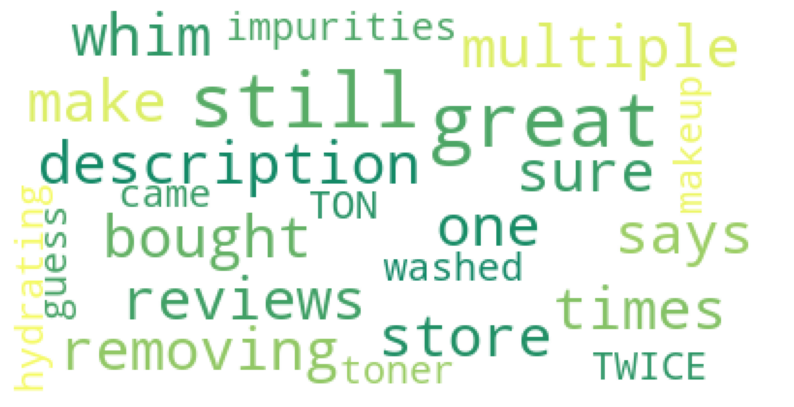

<IPython.core.display.Javascript object>

In [22]:
generate_wordcloud(super_words)

**Wordcloud showing words commonly associated with the Daily Microfoliant product**

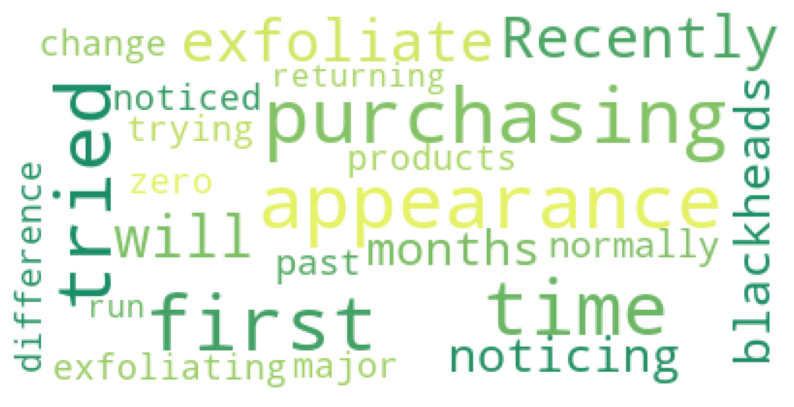

<IPython.core.display.Javascript object>

In [23]:
generate_wordcloud(micro_words)

**Wordcloud showing words commonly associated with the Hydro Masque Exfoliant product**

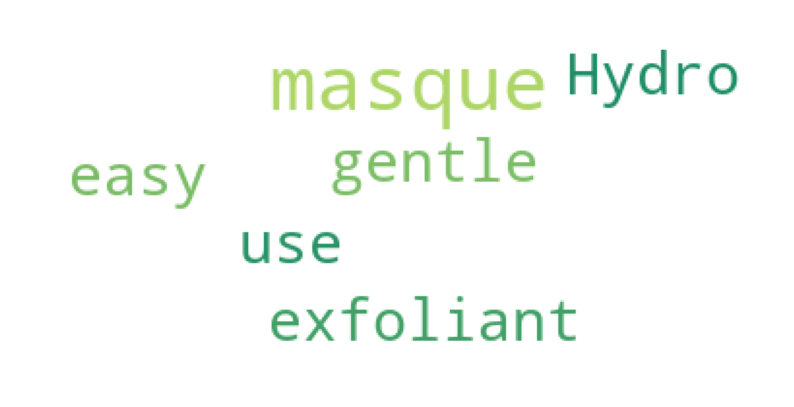

<IPython.core.display.Javascript object>

In [24]:
generate_wordcloud(exfo_words)

**Dropping the unwanted columns**

In [25]:
cols = ["Brand", "Scrape_Date", "Review_Location"]
df = df.drop(columns=cols)

<IPython.core.display.Javascript object>

In [26]:
df.head(2)

,Verified_Buyer,Review_Date,Review_Upvotes,Review_Downvotes,Product,Sentiment,Review,Review_length
0,No,Less than 1 month,0,0,Multi-Vitamin Thermafoliant,2,Perfect Love using this on my face while in the shower. Heats up and gives a light scrub nicely,95
1,No,Less than 1 month,0,0,Multi-Vitamin Thermafoliant,2,You need this Even better than the daily microfoliant. I'm obsessed. My skin is SO MUCH smoother,96


<IPython.core.display.Javascript object>

**Using TF-IDF I would remove stopwords, tokenize and vectorize**


In [27]:
# instantiating the TfidfVectorizer, then fit_transform the review column

tfidf_vec = TfidfVectorizer(stop_words="english")
review_data = tfidf_vec.fit_transform(df["Review"])
review_data

<4146x5105 sparse matrix of type '<class 'numpy.float64'>'
	with 83813 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [28]:
# viewing tokens created
idx_word_vocab = {idx: key for key, idx in tfidf_vec.vocabulary_.items()}
idx_word_vocab

{3191: 'perfect',
 2628: 'love',
 4838: 'using',
 1653: 'face',
 4023: 'shower',
 2114: 'heats',
 1943: 'gives',
 2541: 'light',
 3902: 'scrub',
 2954: 'nicely',
 2932: 'need',
 464: 'better',
 1095: 'daily',
 2778: 'microfoliant',
 3009: 'obsessed',
 4073: 'skin',
 4134: 'smoother',
 804: 'clean',
 1487: 'enjoy',
 3411: 'product',
 2603: 'look',
 1846: 'forward',
 3555: 'really',
 1721: 'feels',
 2012: 'great',
 4368: 'stuff',
 4856: 've',
 4714: 'tried',
 2548: 'like',
 297: 'apply',
 2577: 'little',
 4016: 'shot',
 4914: 'warm',
 1978: 'good',
 2026: 'gritty',
 1441: 'effects',
 1476: 'encountered',
 3316: 'positive',
 3047: 'ones',
 1591: 'exfoliates',
 4130: 'smooth',
 2381: 'irritation',
 3540: 'reaction',
 2148: 'highly',
 3581: 'recommended',
 652: 'buy',
 3959: 'seriously',
 2953: 'nice',
 4829: 'use',
 4967: 'wet',
 1397: 'dry',
 995: 'control',
 87: 'abrasive',
 2508: 'leaves',
 4158: 'soft',
 1383: 'drenched',
 4890: 'vitamins',
 93: 'absolutely',
 4725: 'truly',
 2900: 'mu

<IPython.core.display.Javascript object>

In [29]:
# converting vectorized data to a dataframe
review_data = review_data.toarray()
review_data = pd.DataFrame(data=review_data, columns=idx_word_vocab.values())
print(review_data.shape)
review_data.head()

(4146, 5105)


,perfect,love,using,face,shower,heats,gives,light,scrub,nicely,need,better,daily,microfoliant,obsessed,skin,smoother,clean,enjoy,product,look,forward,really,feels,great,stuff,ve,tried,like,apply,little,shot,warm,good,gritty,effects,encountered,positive,ones,exfoliates,smooth,irritation,reaction,highly,recommended,buy,seriously,nice,use,wet,dry,control,abrasive,leaves,soft,drenched,vitamins,absolutely,truly,multivitamin,thermafoliant,years,happy,purchase,directly,longer,available,ulta,store,favorite,definitely,excelent,exfoliate,helped,winter,dermalogica,twice,weekly,usually,whilst,waiting,conditioner,soak,exfoliating,body,super,sensitive,prone,blotches,oily,zone,does,amazing,things,hydrates,sloughs,dead,cells,causes,zero,glowing,deep,facial,couldn,live,makeup,goes,feel,gently,exfoliated,recommend,best,exfoliant,products,faves,thermofoliant,looking,renewed,rejuvenated,follow,power,recovery,masque,looks,just,professional,everytime,subtle,refreshingly,recommendâ,yes,keeps,pores,helping,prevent,breakouts,silk,used,alot,scub,works,welland,afer,feeling,start,work,minute,hits,tingling,sensation,gets,refreshed,wonderfully,fingertips,thermfoliant,initial,warmth,quite,surprising,silky,new,baby,peel,gel,times,results,brighter,needed,told,discontinued,thankfully,placed,order,polish,debris,removed,warming,glad,brought,exfoliator,glow,smells,makes,item,changes,texture,thanks,noticeable,difference,tel,skins,week,weeks,complexion,dark,spots,fading,improved,started,totally,line,help,eliminate,outbreak,pimples,areas,nose,crease,mouth,chin,blackheads,clogged,tend,gather,55,mild,irritate,reactive,day,night,routine,favorites,thing,fan,smell,gentle,repeat,treat,massage,combines,physical,chemical,exfoliants,time,beauty,regimen,freshness,immediately,dramatically,exceptional,older,flaky,bumpy,heated,softer,dryness,lovely,absolute,benefits,visible,self,care,practice,taht,ut,ahs,working,far,aspects,excellent,effective,wonderful,tube,simply,53,age,supple,skincare,morning,neck,launched,ago,radiant,make,smoothly,warms,creamy,extra,heating,effect,thermal,glowy,worried,going,rough,complete,opposite,doing,job,boyfriend,shaves,head,regularly,uses,cleanse,scalp,wanted,asking,talking,different,people,took,hr,check,instead,realized,got,home,checked,case,coming,mail,decided,try,mask,did,considering,hefty,price,certainly,biore,individually,contained,masks,foil,packets,past,prefer,brick,mortar,stores,soooo,anytime,hassle,polisher,conjunction,visable,glows,beware,slight,sure,let,sit,holy,moly,born,babies,booty,disappointed,advertised,tough,husband,rid,stubborn,turn,raw,pleasant,scent,loves,action,unique,long,compares,goodness,fresh,having,cleansing,mini,quick,œpick,upâ,cleanser,way,burns,allergic,reactions,turned,red,extremely,dryâ,cream,primer,component,needs,softened,stop,sending,promotions,lot,excess,sebum,cancel,recurring,shipment,anymore,favourite,manual,sugary,sister,religiously,days,easy,delicate,goldilocks,harsh,cool,surprise,awaits,surprised,felt,2x,knows,experience,polished,preventing,doesn,thought,ok,suggested,leave,didn,type,form,45,25,year,old,run,literally,woman,wrinkles,brand,removes,buildup,staple,household,friday,nights,comes,stay,weekend,chemicals,want,wonders,sludge,funky,heat,scrubs,feature,luv,tell,don,lived,amazed,leaving,ready,absorb,evenly,provided,regenerate,improving,smoothness,suppleness,appearance,shrinked,strong,peeling,moment,cleans,toasty,scrubby,noticed,applications,wow,completely,loved,aspect,right,hyper,pigmentation,helps,refine,lease,extraordinary,evens,tone,sparkling,refined,alternating,lactic,acid,glycolic,peels,fun,notice,muddiness,forget,deliciously,fantastic,added,...,sandpaper,develop,tries,spent,bump,isolated,discovering,teeth,visibility,bette,ruined,somone,conscious,applica,fot,adults,artist,magically,aka,bullet,mighty,successfully,15yrs,waxy,frankly,peepee,subscription,measuring,relatively,shampoo,burny,mirror,hives,insisted,waaaaaaay,oomph,looooovvee,nonexistent,transform,sebaceous,filaments,remained,survived,025,risky,tes

<IPython.core.display.Javascript object>

In [30]:
# merging vectorized review column with previous variables
df_all = pd.merge(
    df.drop(columns="Review"), review_data, left_index=True, right_index=True
)
df_all.head()

,Verified_Buyer,Review_Date,Review_Upvotes,Review_Downvotes,Product,Sentiment,Review_length,perfect,love,using,face,shower,heats,gives,light,scrub,nicely,need,better,daily,microfoliant,obsessed,skin,smoother,clean,enjoy,product,look,forward,really,feels,great,stuff,ve,tried,like,apply,little,shot,warm,good,gritty,effects,encountered,positive,ones,exfoliates,smooth,irritation,reaction,highly,recommended,buy,seriously,nice,use,wet,dry,control,abrasive,leaves,soft,drenched,vitamins,absolutely,truly,multivitamin,thermafoliant,years,happy,purchase,directly,longer,available,ulta,store,favorite,definitely,excelent,exfoliate,helped,winter,dermalogica,twice,weekly,usually,whilst,waiting,conditioner,soak,exfoliating,body,super,sensitive,prone,blotches,oily,zone,does,amazing,things,hydrates,sloughs,dead,cells,causes,zero,glowing,deep,facial,couldn,live,makeup,goes,feel,gently,exfoliated,recommend,best,exfoliant,products,faves,thermofoliant,looking,renewed,rejuvenated,follow,power,recovery,masque,looks,just,professional,everytime,subtle,refreshingly,recommendâ,yes,keeps,pores,helping,prevent,breakouts,silk,used,alot,scub,works,welland,afer,feeling,start,work,minute,hits,tingling,sensation,gets,refreshed,wonderfully,fingertips,thermfoliant,initial,warmth,quite,surprising,silky,new,baby,peel,gel,times,results,brighter,needed,told,discontinued,thankfully,placed,order,polish,debris,removed,warming,glad,brought,exfoliator,glow,smells,makes,item,changes,texture,thanks,noticeable,difference,tel,skins,week,weeks,complexion,dark,spots,fading,improved,started,totally,line,help,eliminate,outbreak,pimples,areas,nose,crease,mouth,chin,blackheads,clogged,tend,gather,55,mild,irritate,reactive,day,night,routine,favorites,thing,fan,smell,gentle,repeat,treat,massage,combines,physical,chemical,exfoliants,time,beauty,regimen,freshness,immediately,dramatically,exceptional,older,flaky,bumpy,heated,softer,dryness,lovely,absolute,benefits,visible,self,care,practice,taht,ut,ahs,working,far,aspects,excellent,effective,wonderful,tube,simply,53,age,supple,skincare,morning,neck,launched,ago,radiant,make,smoothly,warms,creamy,extra,heating,effect,thermal,glowy,worried,going,rough,complete,opposite,doing,job,boyfriend,shaves,head,regularly,uses,cleanse,scalp,wanted,asking,talking,different,people,took,hr,check,instead,realized,got,home,checked,case,coming,mail,decided,try,mask,did,considering,hefty,price,certainly,biore,individually,contained,masks,foil,packets,past,prefer,brick,mortar,stores,soooo,anytime,hassle,polisher,conjunction,visable,glows,beware,slight,sure,let,sit,holy,moly,born,babies,booty,disappointed,advertised,tough,husband,rid,stubborn,turn,raw,pleasant,scent,loves,action,unique,long,compares,goodness,fresh,having,cleansing,mini,quick,œpick,upâ,cleanser,way,burns,allergic,reactions,turned,red,extremely,dryâ,cream,primer,component,needs,softened,stop,sending,promotions,lot,excess,sebum,cancel,recurring,shipment,anymore,favourite,manual,sugary,sister,religiously,days,easy,delicate,goldilocks,harsh,cool,surprise,awaits,surprised,felt,2x,knows,experience,polished,preventing,doesn,thought,ok,suggested,leave,didn,type,form,45,25,year,old,run,literally,woman,wrinkles,brand,removes,buildup,staple,household,friday,nights,comes,stay,weekend,chemicals,want,wonders,sludge,funky,heat,scrubs,feature,luv,tell,don,lived,amazed,leaving,ready,absorb,evenly,provided,regenerate,improving,smoothness,suppleness,appearance,shrinked,strong,peeling,moment,cleans,toasty,scrubby,noticed,applications,wow,completely,loved,aspect,right,hyper,pigmentation,helps,refine,lease,extraordinary,evens,tone,sparkling,refined,alternating,lactic,acid,glycolic,peels,...,sandpaper,develop,tries,spent,bump,isolated,discovering,teeth,visibility,bette,ruined,somone,conscious,applica,fot,adults,artist,magically,aka,bullet,mighty,successfully,15yrs,waxy,frankly,peepee,subscription,measuring,relatively,shampoo,burny,mirror,hives,insisted,waaaaaaay,oomph,looooovvee,nonexistent,transform,sebaceous,filame

<IPython.core.display.Javascript object>

**Splitting into train and test data**

In [31]:
RANDOM_STATE = 100
TEST_SIZE = 0.2
TARGET = "Sentiment"

<IPython.core.display.Javascript object>

In [32]:
# Independent features (Matrix)
X = df_all.drop(columns=TARGET)

# Target variable (Vector)
y = df_all[TARGET]

# Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3316, 5111), (830, 5111), (3316,), (830,))

<IPython.core.display.Javascript object>

There's a need to preprocess the previous variables 

In [33]:
# Selecting columns to perform preprocessing on
vars_to_encode = ["Review_Date", "Product", "Verified_Buyer"]
vars_to_scale = ["Review_Upvotes", "Review_Downvotes", "Review_length"]

# ===== OE =====
oe = OrdinalEncoder(handle_unknown="error")

# ===== Scaler =====
scaler = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[("oe", oe, vars_to_encode), ("scaler", scaler, vars_to_scale)],
    remainder="passthrough",
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('oe', OrdinalEncoder(),
                                 ['Review_Date', 'Product', 'Verified_Buyer']),
                                ('scaler', MinMaxScaler(),
                                 ['Review_Upvotes', 'Review_Downvotes',
                                  'Review_length'])])

<IPython.core.display.Javascript object>

In [34]:
# View preprocessed info
tr = preprocessor.fit_transform(X_train)
pd.DataFrame(tr, columns=preprocessor.get_feature_names_out()).head()

,oe__Review_Date,oe__Product,oe__Verified_Buyer,scaler__Review_Upvotes,scaler__Review_Downvotes,scaler__Review_length,remainder__perfect,remainder__love,remainder__using,remainder__face,remainder__shower,remainder__heats,remainder__gives,remainder__light,remainder__scrub,remainder__nicely,remainder__need,remainder__better,remainder__daily,remainder__microfoliant,remainder__obsessed,remainder__skin,remainder__smoother,remainder__clean,remainder__enjoy,remainder__product,remainder__look,remainder__forward,remainder__really,remainder__feels,remainder__great,remainder__stuff,remainder__ve,remainder__tried,remainder__like,remainder__apply,remainder__little,remainder__shot,remainder__warm,remainder__good,remainder__gritty,remainder__effects,remainder__encountered,remainder__positive,remainder__ones,remainder__exfoliates,remainder__smooth,remainder__irritation,remainder__reaction,remainder__highly,remainder__recommended,remainder__buy,remainder__seriously,remainder__nice,remainder__use,remainder__wet,remainder__dry,remainder__control,remainder__abrasive,remainder__leaves,remainder__soft,remainder__drenched,remainder__vitamins,remainder__absolutely,remainder__truly,remainder__multivitamin,remainder__thermafoliant,remainder__years,remainder__happy,remainder__purchase,remainder__directly,remainder__longer,remainder__available,remainder__ulta,remainder__store,remainder__favorite,remainder__definitely,remainder__excelent,remainder__exfoliate,remainder__helped,remainder__winter,remainder__dermalogica,remainder__twice,remainder__weekly,remainder__usually,remainder__whilst,remainder__waiting,remainder__conditioner,remainder__soak,remainder__exfoliating,remainder__body,remainder__super,remainder__sensitive,remainder__prone,remainder__blotches,remainder__oily,remainder__zone,remainder__does,remainder__amazing,remainder__things,remainder__hydrates,remainder__sloughs,remainder__dead,remainder__cells,remainder__causes,remainder__zero,remainder__glowing,remainder__deep,remainder__facial,remainder__couldn,remainder__live,remainder__makeup,remainder__goes,remainder__feel,remainder__gently,remainder__exfoliated,remainder__recommend,remainder__best,remainder__exfoliant,remainder__products,remainder__faves,remainder__thermofoliant,remainder__looking,remainder__renewed,remainder__rejuvenated,remainder__follow,remainder__power,remainder__recovery,remainder__masque,remainder__looks,remainder__just,remainder__professional,remainder__everytime,remainder__subtle,remainder__refreshingly,remainder__recommendâ,remainder__yes,remainder__keeps,remainder__pores,remainder__helping,remainder__prevent,remainder__breakouts,remainder__silk,remainder__used,remainder__alot,remainder__scub,remainder__works,remainder__welland,remainder__afer,remainder__feeling,remainder__start,remainder__work,remainder__minute,remainder__hits,remainder__tingling,remainder__sensation,remainder__gets,remainder__refreshed,remainder__wonderfully,remainder__fingertips,remainder__thermfoliant,remainder__initial,remainder__warmth,remainder__quite,remainder__surprising,remainder__silky,remainder__new,remainder__baby,remainder__peel,remainder__gel,remainder__times,remainder__results,remainder__brighter,remainder__needed,remainder__told,remainder__discontinued,remainder__thankfully,remainder__placed,remainder__order,remainder__polish,remainder__debris,remainder__removed,remainder__warming,remainder__glad,remainder__brought,remainder__exfoliator,remainder__glow,remainder__smells,remainder__makes,remainder__item,remainder__changes,remainder__texture,remainder__thanks,remainder__noticeable,remainder__difference,remainder__tel,remainder__skins,remainder__week,remainder__weeks,remainder__complexion,remainder__dark,remainder__spots,remainder__fading,remainder__improved,remainder__started,remainder__totally,remainder__line,remainder__help,remainder__eliminate,remainder__outbreak,remainder__pimples,remainder__areas,remainder__nose,remainder__crease,remainder__mouth,remainder__chin,remainder__blackheads,rema

<IPython.core.display.Javascript object>

<a id="modeltrain"></a>
### Model training
Next is to train the machine learning model. 

Logistic regression, a supervised learning algorithm will be used.

In [35]:
# Define model
model = LogisticRegression()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Preprocessing of training data, fit model
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)

<IPython.core.display.Javascript object>

<a id="modeleval"></a>
### Model evaluation
Evaluating the performance of the model on the test set using metrics such as accuracy, precision, recall, and F1-score to measure the performance of the model. 

These metrics give us an idea of how well the model is able to predict the correct sentiment label for each review.

A visualization of the performance of the model using a confusion matrix to show the number of true positives, false positives, true negatives, and false negatives. 

In [36]:
# Evaluate the model
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average="macro")
recall = recall_score(y_test, preds, average="macro")
f1 = f1_score(y_test, preds, average="macro")
confusion = confusion_matrix(y_test, preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion matrix:\n", confusion)


Accuracy: 0.7457831325301205
Precision: 0.6771678540182476
Recall: 0.4472258874521187
F1-score: 0.459807007299548
Confusion matrix:
 [[  2  23  15]
 [  1  75 143]
 [  0  29 542]]


<IPython.core.display.Javascript object>

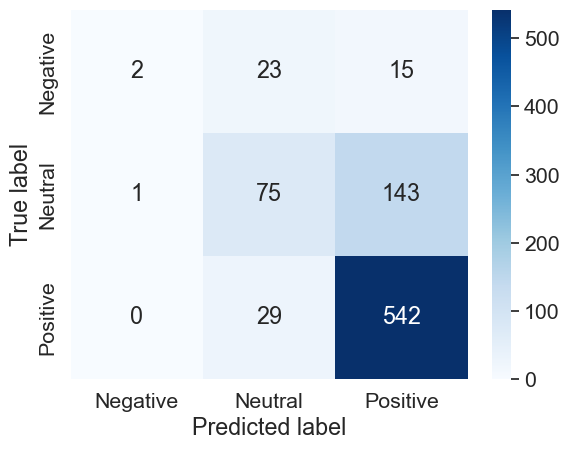

<IPython.core.display.Javascript object>

In [37]:
# visualizing confusion matrix
con_matrix = confusion.tolist()
labels = ["Negative", "Neutral", "Positive"]

# Create heatmap
sns.set(font_scale=1.4)
sns.heatmap(
    con_matrix,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

The model correctly identified 2 negative reviews, 75 neutral reviews, and 542 positive reviews. 

However, it misclassified 23 negative reviews as neutral, 15 negative reviews as positive, 29 neutral reviews as negative, and 143 neutral reviews as positive.

### Conclusion
In conclusion, an ML model that can predict whether a review is positive, neutral or negative involving several steps, including data preprocessing, feature extraction, model training, evaluation was built. 

Following these steps helped to build a model that accurately predicts the sentiment of the reviews and provides valuable insights into the opinions and experiences of the customers.